In [1]:
try:
    from undi import MuonNuclearInteraction
except (ImportError, ModuleNotFoundError):
    import sys
    sys.path.append('../../undi/')
    from undi import MuonNuclearInteraction
import matplotlib.pyplot as plt
import numpy as np
import time

# Define lattice structure

Muon site $T_1$(0.2,  0.0,  0.15) define in the paper https://arxiv.org/pdf/1201.5406.pdf or https://doi.org/10.1016/j.phpro.2012.04.056

In [2]:
angtom=1.0e-10                      # m
elementary_charge=1.6021766E-19     # Coulomb = ampere ⋅ second

Cu_Quadrupole_moment = -0.211e-28   # m^-2 
La_Quadrupole_moment =  0.22e-28    # m^-2

OmegaQmu=0                          #  quadrupolar coupling constant (Hz) of Mu define in undi code
OmegaQI_Cu=  2*np.pi*34.0e6         #  213.6e6 or 194.8e6 # Hz (quadrupolar coupling constant)
OmegaQI_La=  2*np.pi*6.4e6          #   40.2e6                 (quadrupolar coupling constant)
a0=3.80 * angtom
b0=a0
c0=13.12 * angtom
cell=[a0,b0,c0]                     # lattice parameter
etaCu=0.02                          # eta, extract form paper
etaLa=0.03                          

scale=1/1.

atoms = [
	    {'Position': np.array([0.2,  0.0,  0.15])*cell,
	     'Label': 'mu'},

	    {'Position': np.array([0.0, 0.0, 0.0])*cell,
	     'Label': 'Cu',
	     'ElectricQuadrupoleMoment': Cu_Quadrupole_moment,
         'OmegaQI': OmegaQI_Cu,
         'OmegaQmu': OmegaQmu,
         'eta': etaCu,
	    },
	    
	    {'Position': np.array([1.0, 0.0, 0.0])*cell,
	     'Label': 'Cu',
	     'ElectricQuadrupoleMoment': Cu_Quadrupole_moment,
         'OmegaQI': OmegaQI_Cu,
         'OmegaQmu': OmegaQmu,
         'eta': etaCu,
	    },
	    
	    {'Position': np.array([0.5, 0.5, 0.13892])*cell,
	     'Label': 'La',
	     'ElectricQuadrupoleMoment': La_Quadrupole_moment,
         'OmegaQI': OmegaQI_La,
         'OmegaQmu': OmegaQmu,
         'eta': etaLa,
	    },
	    
	    {'Position': np.array([0.5, -0.5, 0.13892])*cell,
	     'Label': 'La',
	     'ElectricQuadrupoleMoment': La_Quadrupole_moment,
         'OmegaQI': OmegaQI_La,
         'OmegaQmu': OmegaQmu,
         'eta': etaLa,
	    },
	    
	    {'Position': np.array([0.0,  0.0,  0.36108])*cell,
	     'Label': 'La',
	     'ElectricQuadrupoleMoment': La_Quadrupole_moment,
         'OmegaQI': OmegaQI_La,
         'OmegaQmu': OmegaQmu,
         'eta': etaLa,
	    }
        ] 

# How we define electric field gradient from a point charge model

Define in ../../undi/undi.py code

In [3]:
elementary_charge=1.6021766E-19 # Coulomb = ampere ⋅ second
h=6.6260693e-34 # Js
hbar=h/(2*np.pi) # Js

def Vzz_for_unit_charge_at_distance(p_mu, p_N):
    x=p_N-p_mu
    r = np.linalg.norm(x)
    r*=1.0e-0   # convert to angs
    epsilon0 = 8.8541878E-12 # ampere^2 ⋅ kilogram^−1 ⋅ meter^−3 ⋅ second^4
    elementary_charge=1.6021766E-19 # Coulomb = ampere ⋅ second
    Vzz = (2./(4 * np.pi * epsilon0)) * (elementary_charge / (r**3))
    return Vzz

def Vzz_from_Celio_PRL():
    # 0.27 angstrom^−3 is from PRL 39 836
    # (4 pi epsilon_0)^−1 (0.27 angstrom^−3) elementary_charge = 3.8879043E20 meter^−2 ⋅ volts
    Vzz = 1.02702 * 3.8879043E20 # the factor 1.02702 gives exactly 3.2e6 s^-1 for omega_q
    return Vzz


def Vzz_Vanad():
    # 0.27 angstrom^−3 is from PRL 39 836
    # (4 pi epsilon_0)^−1 (0.27 angstrom^−3) elementary_charge = 3.8879043E20 meter^−2 ⋅ volts
    Vzz = 1.02702 * 3.8879043E20 # the factor 1.02702 gives exactly 3.2e6 s^-1 for omega_q
    Vzz = 3.75187733297e+22
    return Vzz

def get_V(p_mu, p_N, Vzz):
    x=p_N-p_mu
    n = np.linalg.norm(x)
    x /= n; r = 1. # keeping formula below for clarity
    return -Vzz * ( (3.*np.outer(x,x)-np.eye(3)*(r**2))/r**5 )


# Calculation of Polarization
Based from Celio approx.

In [4]:
###########################################################
# measure process time
t0 = time.clock()
# measure wall time
t0 = time.time()
###########################################################

ttime=20
steps = 200
n=1
tlist = np.linspace(0, ttime*1e-6, steps)
signals = np.zeros([n,steps], dtype=np.float)

# we are not taking a powder average, so I set n=1
# comment on NS.translate_rotate_sample_vec(np.array(threetups[idx]))

threetups = []
for idx, Bmod in enumerate(range(n)):
    NS = MuonNuclearInteraction(atoms, log_level='info')
    threetups.append(NS.random_three_vector())
    #NS.translate_rotate_sample_vec(np.array(threetups[idx]))
    NS.translate_rotate_sample_vec(np.array([1.,1.,1.]))
    print("Computing signal 4 times with ZF {} T...".format(Bmod+1), end='', flush=True)
    signal_lacu = NS.celio(tlist,  k=2)
    for i in range(3):
        print('{}...'.format(i+1), end='', flush=True)
        signal_lacu += NS.celio(tlist, k=2)
    print('done!')
    signal_lacu /= float(i+1+1)
    del NS

    signals[idx]=signal_lacu
    
###########################################################
# measure process time
print (time.clock(), "seconds process time")
# measure wall time
print( time.time() - t0, "seconds wall time")
###########################################################

INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Hilbert space is 16384 dimensional


Computing signal 4 times with ZF 1 T...1...2...3...done!
45.513236 seconds process time
34.78374719619751 seconds wall time


# Save Data...

In [5]:
fi='T1-Final-' 
np.savez(fi+str(n)+'.npz',signals)
file=np.load(fi+str(n)+'.npz')  # load the data if needed
file.files
A=file['arr_0']                 # Read the data
# for i in range(n):  
#     print(A[i])   

# Plot...

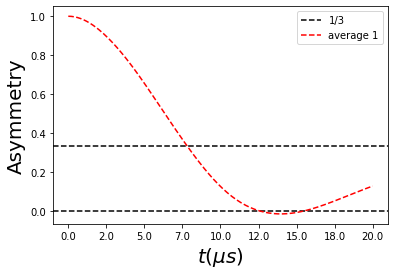

In [6]:
### to see with different direction
fig, axes = plt.subplots(1,1)
axes.axhline(y=1/3., color='k', ls='--', label='1/3')
axes.axhline(y=0., color='k', ls='--')
axes.plot(tlist,signals.sum(axis=0)/float(n),'r--',label='average '+str(n)) # in case of powder averag
ticks = np.round(axes.get_xticks()*10.**6)
axes.set_xticklabels(ticks)
axes.set_xlabel(r'$t (\mu s)$', fontsize=20)
axes.set_ylabel(r'Asymmetry', fontsize=20);
plt.legend()
plt.show()

# Plot Calculated and Extracted Data...

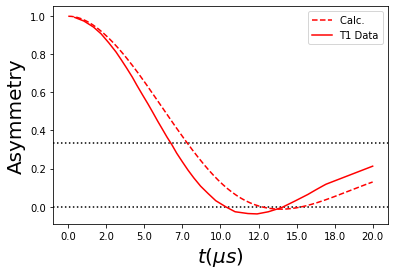

In [7]:
import numpy as np
import matplotlib.pyplot as plt

pre='T1'
filename = pre+'.dat'       # Extract data from the paper
ttime=20
tlist = np.linspace(0, ttime*1e-6, 200)
fi='T1-Final-' 
file=np.load(fi+str(n)+'.npz')  # load the data if needed
file.files
A=file['arr_0']                 # Read the data
# for i in range(n):  
#     print(A[i])
x,y=np.loadtxt(filename,unpack=True)
fig, axes = plt.subplots(1,1)
axes.axhline(y=1/3., color='k', ls=':')
axes.axhline(y=0., color='k', ls=':')
axes.plot(tlist,A.sum(axis=0)/float(n),'r--',label='Calc. ')
axes.plot(x*1e-6,y, 'r',label='T1 Data')
ticks = np.round(axes.get_xticks()*10.**6)
axes.set_xticklabels(ticks)
axes.set_xlabel(r'$t (\mu s)$', fontsize=20)
axes.set_ylabel(r'Asymmetry', fontsize=20);
plt.legend()
plt.show()